In [1]:
import torchaudio
torchaudio.set_audio_backend("soundfile")
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
import torch
print(torch.__version__)
from torch import nn
from tqdm import tqdm
from torch.optim import Adam
import matplotlib.pyplot as plt
import os
import warnings
import gc
from copy import deepcopy
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
import librosa
import numpy as np
import noisereduce as nr
import malaya_speech
from malaya_speech import Pipeline
import IPython.display as ipd
warnings.filterwarnings("ignore")
from pysptk.sptk import rapt
import gc

1.8.0+cu111


# path

In [2]:
X_train_dir = 'train/train/'
X_test_dir = 'public_test/public_test/'
Y_train_path = 'train/meta_train.csv'

# help functions

In [3]:
def norm_mel(y, sr):
    mel = librosa.feature.melspectrogram(y, sr = sr, n_mels = 80,hop_length=512)
    mel = librosa.power_to_db(mel, ref=np.max)
    return mel.T

def plot(y, sr):
    mel = norm_mel(y, sr)
    fig, axs = plt.subplots(2, figsize=(10, 8))
    axs[0].plot(y)
    im = axs[1].imshow(np.rot90(mel), aspect='auto', interpolation='none')
    fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=axs[1])
    print('mel shape:',mel.shape)
    plt.show()

mel shape: (157, 80)


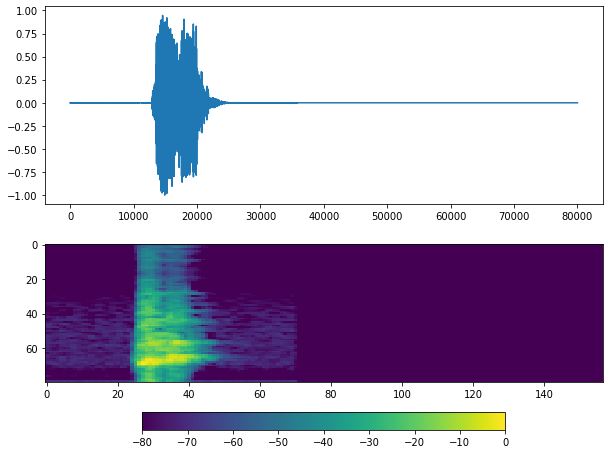

In [4]:
files = os.listdir(X_train_dir)
files.sort()
f = files[40]
y, sr = malaya_speech.load(X_train_dir+f)
plot(y,sr)
ipd.Audio(y, rate = sr)

# 取基頻

mel shape: (1, 80)


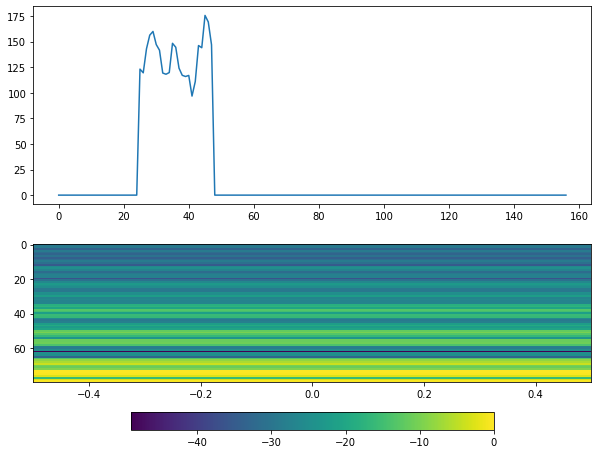

In [5]:
y_基頻 = rapt(y.astype('float32')*32767,sr,hopsize=512)
plot(y_基頻,sr)
ipd.Audio(y_基頻, rate = sr)

# 靜音部分消除

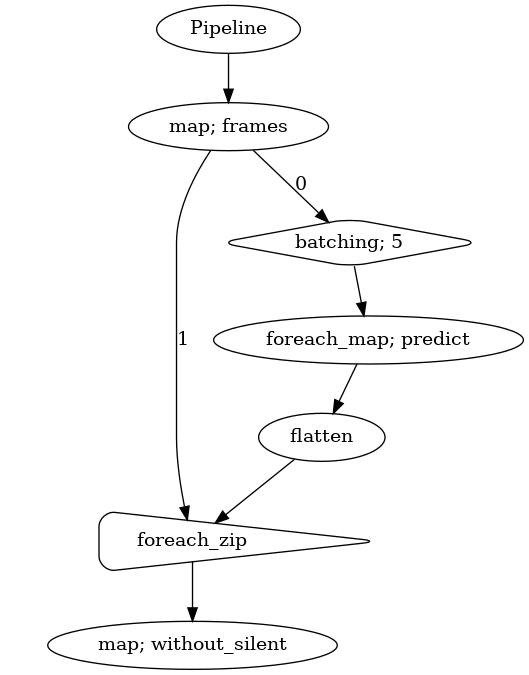

In [6]:
quantized_model = malaya_speech.vad.deep_model(model = 'vggvox-v2', quantized = True)
p = Pipeline()

pipeline_left = (
    p.map(malaya_speech.generator.frames, frame_duration_ms = 30, sample_rate = 16000)
)

pipeline_right = (
    pipeline_left.batching(5)
    .foreach_map(quantized_model.predict)
    .flatten()
)

pipeline_left.foreach_zip(pipeline_right).map(malaya_speech.combine.without_silent,
                                             threshold_to_stop = 0.05)

p.visualize()

In [7]:
def remove_silent(y,sr,time_length=80000):
    y =  p(y)['without_silent']
    if len(y) > time_length:
        y = y[0:0+time_length]
    else:
        y = np.pad(y, (0,time_length-len(y)))
    return y

mel shape: (157, 80)


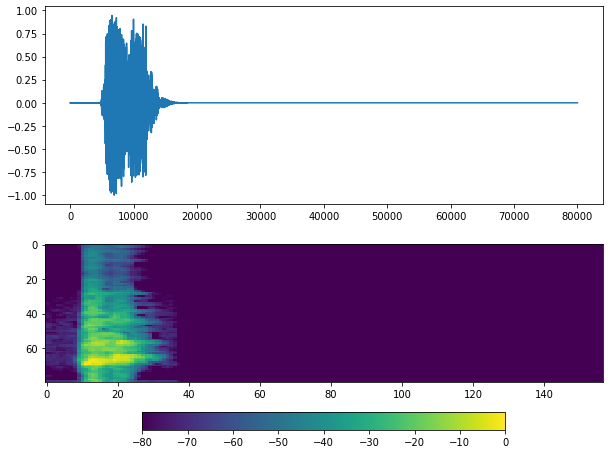

In [8]:
y_without_silent = remove_silent(y,sr)
plot(y_without_silent,sr)
ipd.Audio(y_without_silent, rate = sr)

# mel shape: (157, 80) #固定

# wav 2 features flow

In [9]:
def wav2featuresflow(y, sr):
    y_without_silent = remove_silent(y,sr)
    melspectrogram = np.rot90(norm_mel(y, sr))
    return melspectrogram

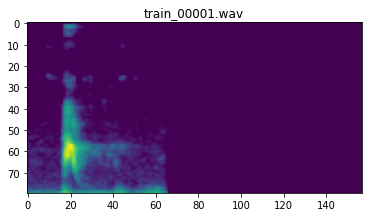

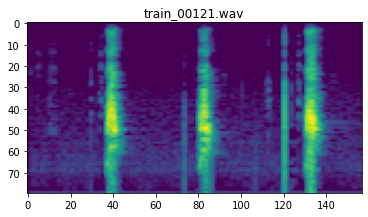

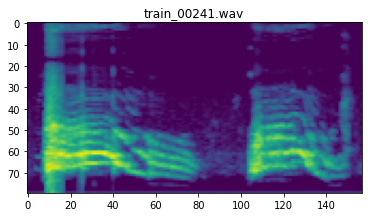

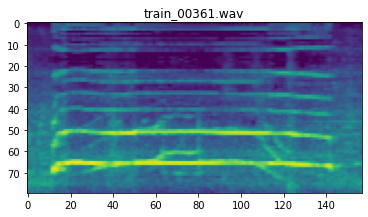

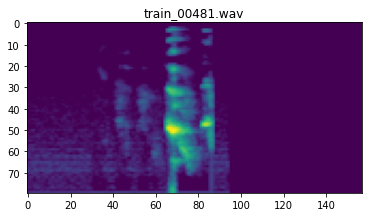

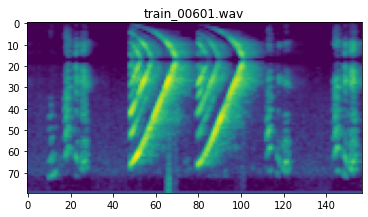

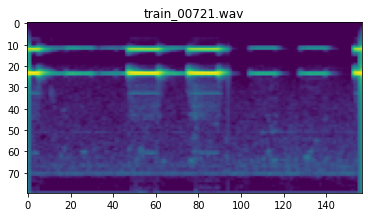

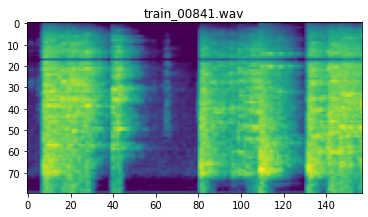

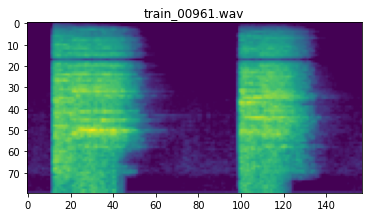

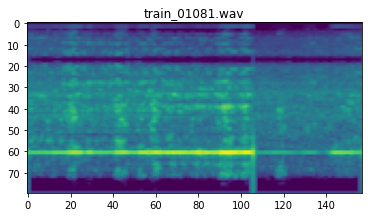

In [10]:
files = os.listdir(X_train_dir)
files.sort()
for f in files[::120]:
    y,sr = malaya_speech.load(X_train_dir+f)
    melspectrogram = wav2featuresflow(y,sr=16000)
    plt.imshow(melspectrogram)
    plt.title(f)
    plt.show()

# preprocessing 

In [11]:
def preprocessing_X(wav_dir):
    files = os.listdir(wav_dir)
    files.sort() #正確排序很重要!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    X = torch.FloatTensor([])
    for f in tqdm(files[:]):
        try:
            samples, sample_rate = malaya_speech.load(X_train_dir+f)
            melspectrogram = wav2featuresflow(samples,sr=sample_rate)
            melspectrogram = melspectrogram.reshape(-1,80,157).copy()
            melspectrogram = torch.from_numpy(melspectrogram)
            X = torch.cat([X,torch.unsqueeze(melspectrogram,0)],dim=0)
            gc.collect()
        except:
            print(f)
    print('X shape:',X.shape)
    return X

def preprocessing_Y(file_path):
    Y = pd.read_csv(file_path).iloc[:,:]
    Y = Y[Y.Filename != 'train_01046']
    enc = OneHotEncoder().fit(Y[['Label']])
    Y_one_hot = enc.transform(Y[['Label']]).toarray()
    Y_one_hot = torch.FloatTensor(Y_one_hot)
    print('Y_ont_hot shape',Y_one_hot.shape)
    print('Y_df shape',Y.shape)
    return Y_one_hot,Y

# Load X

In [12]:
#X_train = preprocessing_X(X_train_dir)
#torch.save(X_train,'X_train_吳啟聖教的方法.pt')

In [13]:
X_train = torch.load('X_train_吳啟聖教的方法.pt')

In [14]:
#X_test = preprocessing_X(X_test_dir)
#torch.save(X_test,'X_test_吳啟聖教的方法.pt')

In [15]:
X_test = torch.load('X_test_吳啟聖教的方法.pt')

In [16]:
gc.collect()

20014

In [17]:
X_train.shape,X_test.shape

(torch.Size([1199, 1, 80, 157]), torch.Size([10000, 1, 80, 157]))

# load Y

In [18]:
Y_train,Y_train_df = preprocessing_Y(Y_train_path)
print(Y_train.shape)
map_dict = {}
for l in Y_train_df.Label.unique():
    map_dict[l] = Y_train_df[Y_train_df.Label==l].sample(1)['Remark'].values[0]
map_dict

Y_ont_hot shape torch.Size([1199, 6])
Y_df shape (1199, 3)
torch.Size([1199, 6])


{0: 'Barking',
 1: 'Howling',
 2: 'Crying',
 3: 'COSmoke',
 4: 'GlassBreaking',
 5: 'Vacuum'}

# look some sample

In [19]:
def plot_feature_by_class_name(class_name,X,label_df):
    try:
        plt.figure(figsize=(20,5))
        for i,filename in enumerate([i+'.wav' for i in label_df[label_df.Remark==class_name].sample(3)['Filename'].values]):
            feature = X[int(filename.split('_')[1].split('.')[0])]
            plt.subplot(1,3,i+1)
            plt.imshow(feature[0,:,:])
            title = 'class:{} filename:{}'.format(class_name,filename)
            plt.title(title)
        plt.tight_layout()
        plt.show()
    except:
        print(class_name)

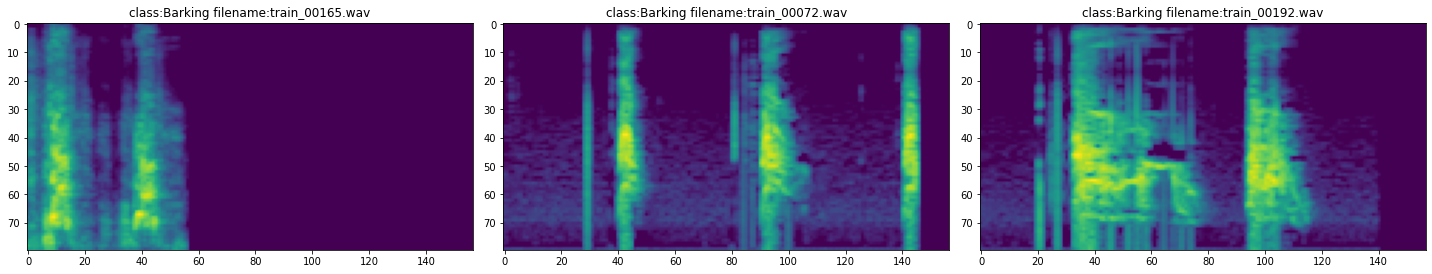

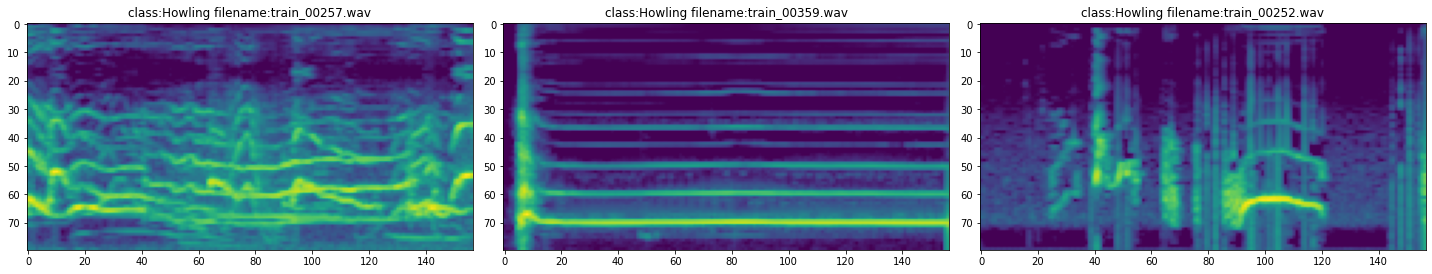

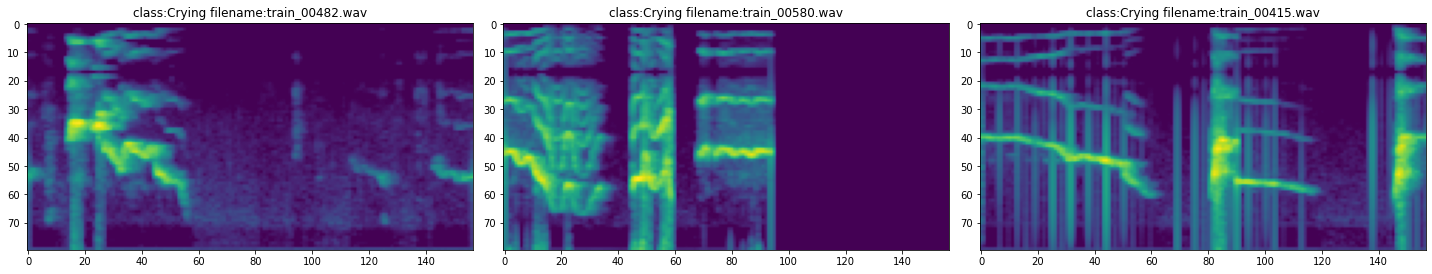

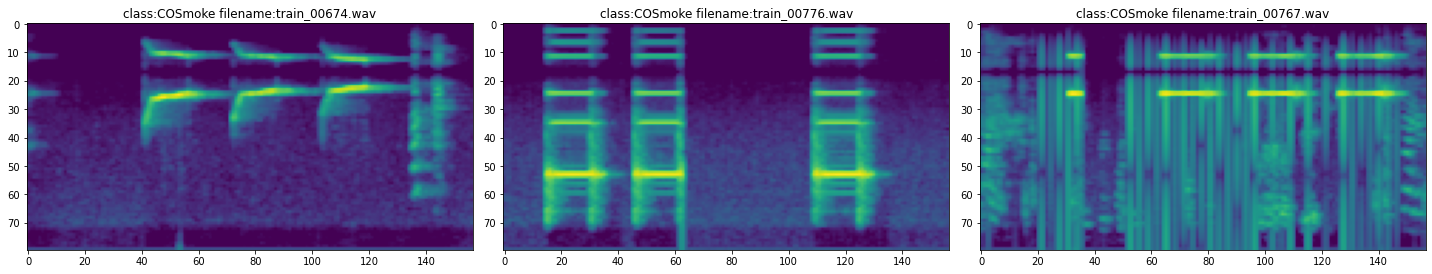

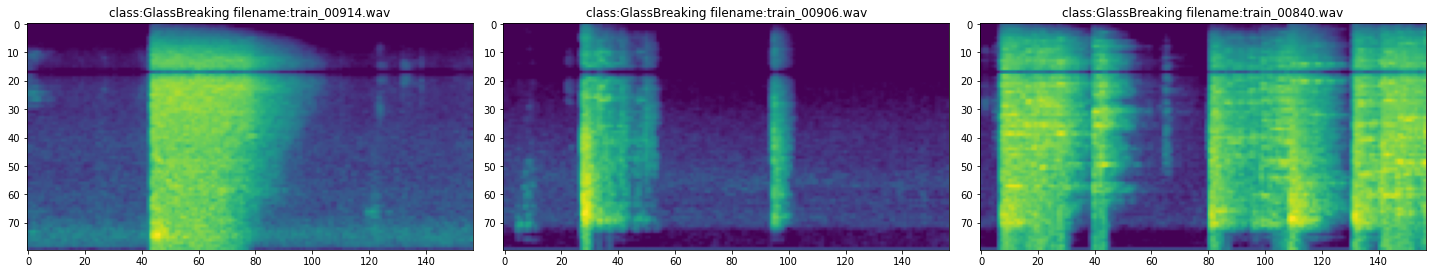

Other


<Figure size 1440x360 with 0 Axes>

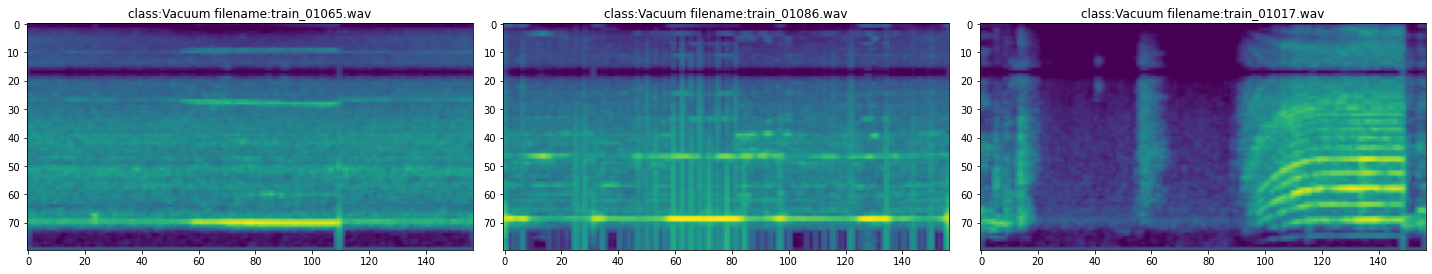

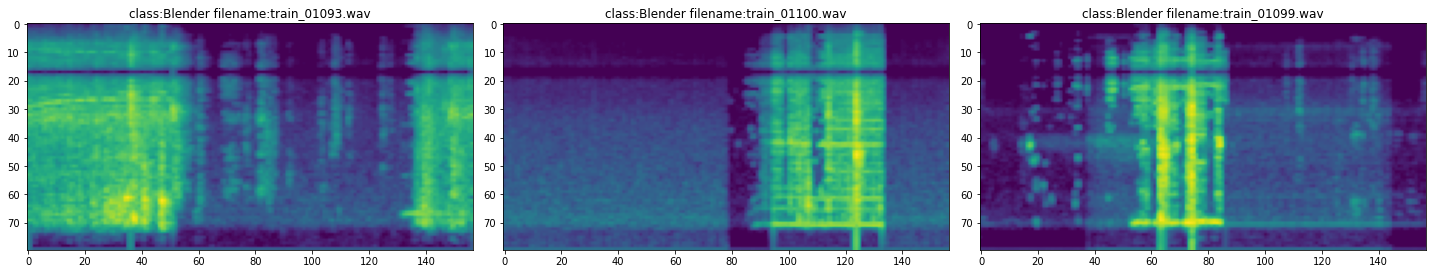

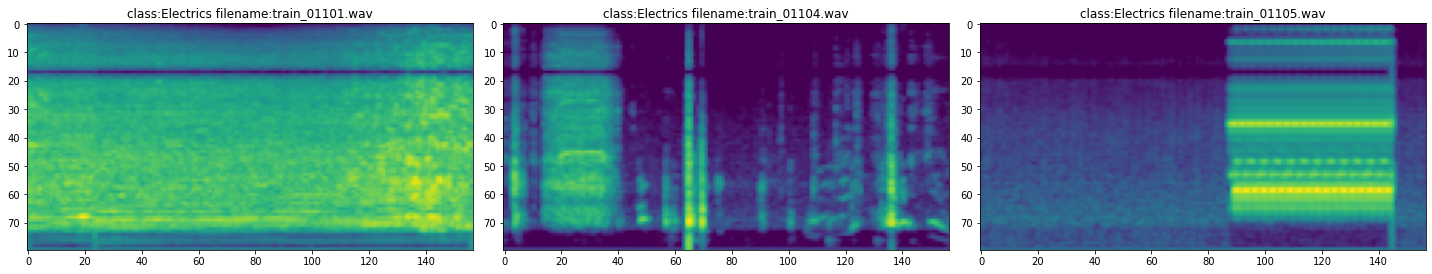

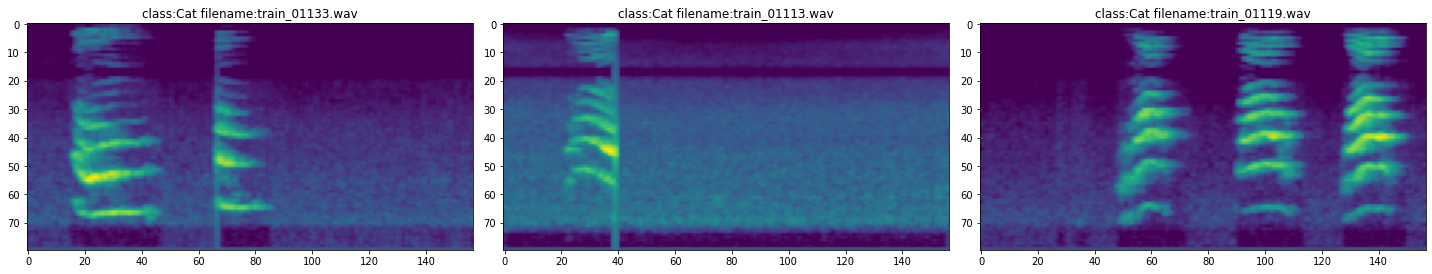

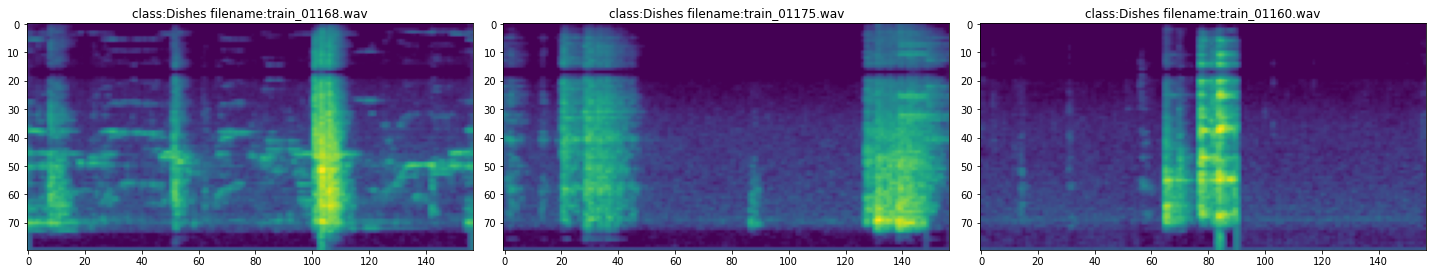

In [20]:
for class_name in Y_train_df.Remark.unique():
    plot_feature_by_class_name(class_name,X_train,Y_train_df)

# train valid split

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size=0.2, random_state=126,stratify=Y_train)
print(X_train.shape)
print(X_valid.shape)
print(pd.DataFrame(y_train.argmax(axis=1)).value_counts())
print(pd.DataFrame(y_valid.argmax(axis=1)).value_counts())

torch.Size([959, 1, 80, 157])
torch.Size([240, 1, 80, 157])
0    160
1    160
2    160
3    160
5    160
4    159
dtype: int64
0    40
1    40
2    40
3    40
4    40
5    40
dtype: int64


# 加入外部數據 to X_train

In [22]:
import joblib
expansion_data = joblib.load('expansion_data.pkl')
for k in expansion_data.keys():
    print(k,len(expansion_data[k]))

Electricssound 34
dogbarking 27
GlassBreakingsound 13
dogcrying 25
Vaccumsound 116
doghowling 18
dishessound 14
Catsound 24


In [23]:
expansion_data['Vaccumsound'] = expansion_data['Vaccumsound'][::4]

In [24]:
for k in expansion_data.keys():
    print(k,len(expansion_data[k]))

Electricssound 34
dogbarking 27
GlassBreakingsound 13
dogcrying 25
Vaccumsound 29
doghowling 18
dishessound 14
Catsound 24


In [25]:
class_idx_map_dict = {}
class_idx_map_dict['dogbarking'] = 0
class_idx_map_dict['doghowling'] = 1
class_idx_map_dict['dogcrying'] = 2
class_idx_map_dict['GlassBreakingsound'] = 4
class_idx_map_dict['Electricssound'] = 5
class_idx_map_dict['Vaccumsound'] = 5
class_idx_map_dict['dishessound'] = 5
class_idx_map_dict['Catsound'] = 5

In [26]:
def create_label(batch_size,length=6,class_idx=0):
    y = torch.tensor([[class_idx] for _ in range(batch_size)])
    y_onehot = torch.zeros([batch_size, length])
    return y_onehot.scatter_(1, y, 1)

extra_X_train = torch.FloatTensor([])
extra_y_train = torch.FloatTensor([])
data_idx = {}
for class_name in tqdm(expansion_data.keys()):
    data = expansion_data[class_name][::2]
    label = create_label(batch_size=len(data),length=6,class_idx=class_idx_map_dict[class_name])
    extra_X_train = torch.cat([extra_X_train,data],dim=0)
    extra_y_train = torch.cat([extra_y_train,label],dim=0)
extra_X_train.shape,extra_y_train.shape

100%|██████████| 8/8 [00:00<00:00, 1499.37it/s]


(torch.Size([94, 1, 80, 157]), torch.Size([94, 6]))

In [27]:
print(expansion_data.keys())

dict_keys(['Electricssound', 'dogbarking', 'GlassBreakingsound', 'dogcrying', 'Vaccumsound', 'doghowling', 'dishessound', 'Catsound'])


# 檢視外部數據

In [28]:
extra_label_df = pd.DataFrame(extra_y_train.argmax(axis=1).detach().numpy(),columns = ['class_name'])
extra_label_df

class_name
0            5
1            5
2            5
3            5
4            5
..         ...
89           5
90           5
91           5
92           5
93           5

[94 rows x 1 columns]

In [29]:
def plot_feature_by_class_name(class_name,X,label_df):
    plt.figure(figsize=(20,5))
    i = 0
    for idx,file_idx in enumerate(label_df[label_df.class_name==class_name].sample(3).index):
        feature = X[int(file_idx)]
        plt.subplot(1,3,i+1)
        plt.imshow(feature[0,:,:])
        title = 'class:{} file_idx:{}'.format(class_name,file_idx)
        plt.title(title)
        i+=1
    plt.tight_layout()
    plt.show()

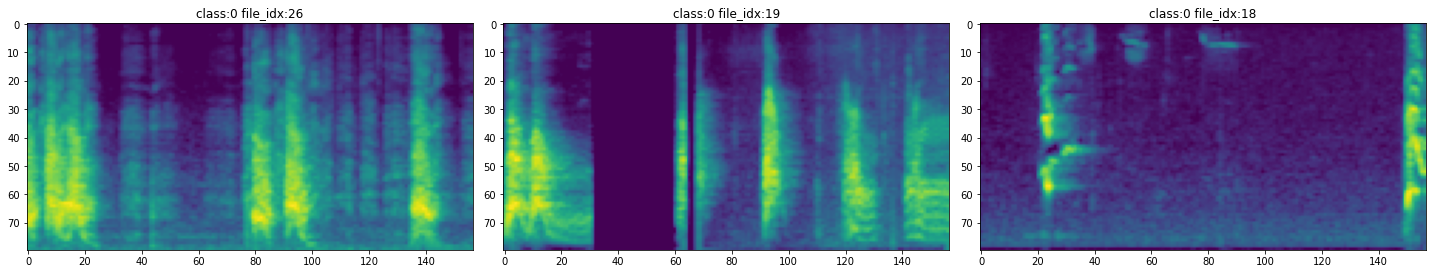

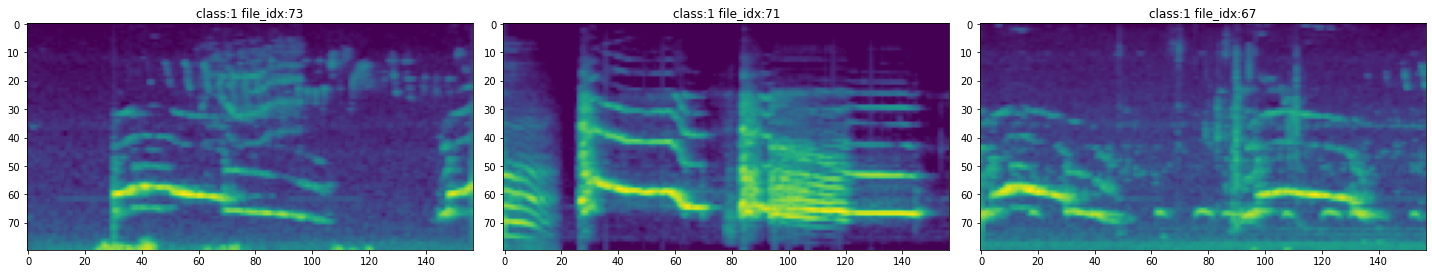

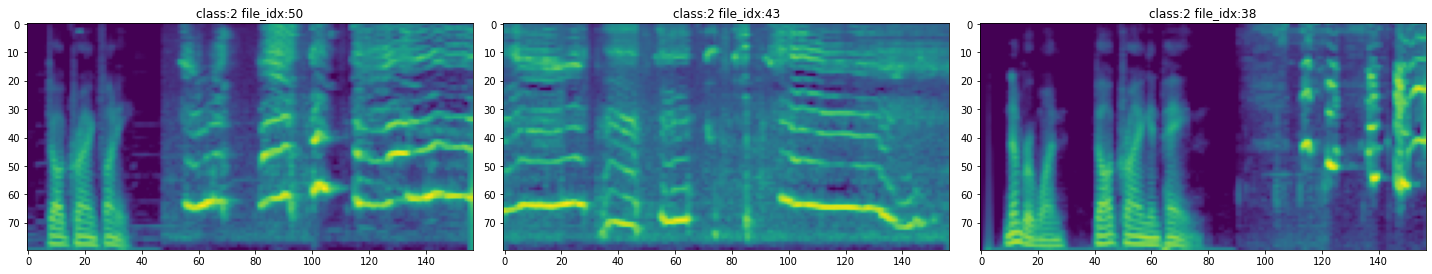

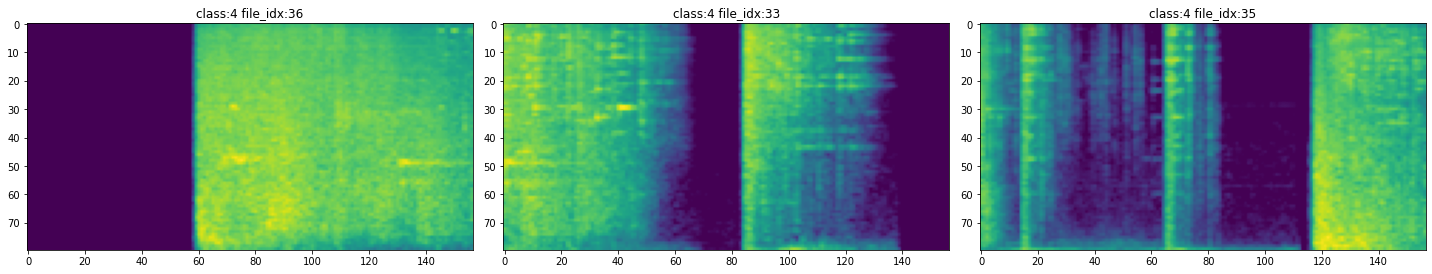

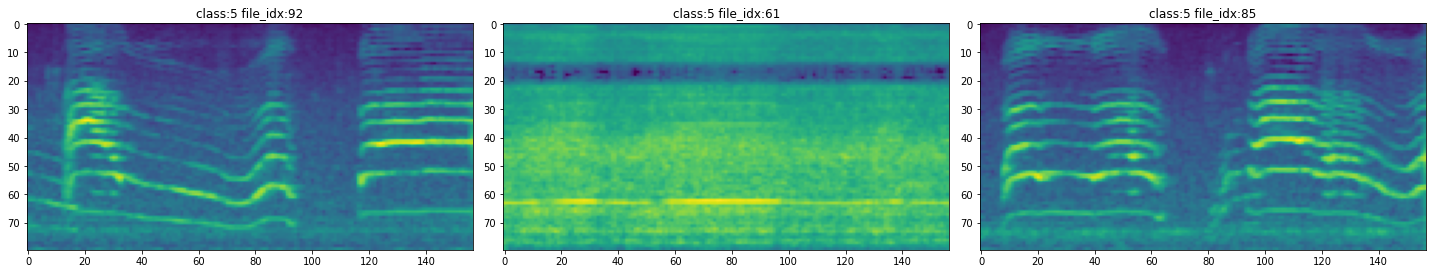

In [30]:
for class_name in sorted(extra_label_df.class_name.unique()):
    plot_feature_by_class_name(class_name,extra_X_train,extra_label_df)

In [31]:
X_train = torch.cat([X_train,extra_X_train],dim=0)
X_train.shape

torch.Size([1053, 1, 80, 157])

In [32]:
y_train = torch.cat([y_train,extra_y_train],dim=0)
y_train.shape

torch.Size([1053, 6])

In [33]:
X_valid.shape

torch.Size([240, 1, 80, 157])

In [34]:
y_valid.shape

torch.Size([240, 6])

#  create pytorch dataloader and save

In [35]:
from torch.utils.data import TensorDataset,DataLoader
trainset = TensorDataset(torch.FloatTensor(X_train.to(torch.float32)),torch.FloatTensor(y_train))
vaildset = TensorDataset(torch.FloatTensor(X_valid.to(torch.float32)),torch.FloatTensor(y_valid))
train_iter = DataLoader(trainset,batch_size=32,num_workers=4)
vaild_iter = DataLoader(vaildset,batch_size=32,num_workers=4)

In [36]:
for bx,by in train_iter:
    print(bx.shape,bx.device) # batch,channel,freq,time
    print(by.shape,by.device) # batch,n_class
    break

torch.Size([32, 1, 80, 157]) cpu
torch.Size([32, 6]) cpu


# define model

In [37]:
import torch.hub
model = torch.hub.load(
    'moskomule/senet.pytorch',
    'se_resnet20',
    num_classes=6)
model.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
print(model)

CifarSEResNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): CifarSEBasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SELayer(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=16, out_features=1, bias=False)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=1, out_features=16, bias=False)
          (3): Sigmoid()
        )
      )
    )
    (1)

Using cache found in /root/.cache/torch/hub/moskomule_senet.pytorch_master


# model forward test

In [38]:
y_hat = model(bx)
print(bx.shape,y_hat.shape)
y_hat.shape

torch.Size([32, 1, 80, 157]) torch.Size([32, 6])


torch.Size([32, 6])

# def train loop

In [39]:
from sklearn.metrics import accuracy_score

def train_step(model,train_iter,loss_fn,optimizer,device):
        model.train()
        total_loss = 0
        total_auc = 0
        for t,(x,y) in enumerate(train_iter):
            x,y = x.to(device),y.to(device)
            y_hat = model(x)
            total_auc += calculate_auc_score(model,x,y)
            loss = loss_fn(y_hat,y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()
        return total_loss/(t+1) ,total_auc/(t+1)

def valid_step(model,vaild_iter,loss_fn,optimizer,device):
    model.eval()
    total_loss = 0
    total_auc = 0
    for t,(x,y) in enumerate(vaild_iter):
        x,y = x.to(device),y.to(device)
        y_hat = model(x)
        total_auc += calculate_auc_score(model,x,y)
        loss = loss_fn(y_hat,y)
        total_loss += loss.item()
    return total_loss/(t+1) ,total_auc/(t+1)

def softmax2onehot(probs):
  probs = torch.FloatTensor(probs)
  max_idx = torch.argmax(probs, 1, keepdim=True)
  one_hot = torch.FloatTensor(probs.shape)
  one_hot.zero_()
  one_hot.scatter_(1, max_idx, 1)
  return one_hot.detach().cpu().numpy().astype(int)

# calculate roc_auc_score
def calculate_auc_score(model,x,y):
    y_hat = model(x).argmax(dim=1).detach().cpu().numpy()
    y = y.argmax(dim=1).detach().cpu().numpy()
    return accuracy_score(y,y_hat)
    #return 0 #roc_auc_score(y_hat,y)


# train_loop
def train(model,train_iter,vaild_iter,optimizer,loss_fn,max_epochs=300,log_interval=10,device=None):
        history = {
            'train_loss':[],
            'valid_loss':[],
            'train_auc':[],
            'valid_auc':[],
            }
        current_loss = np.inf
        best_model = None
        for i in tqdm(range(max_epochs)):
            # step
            train_loss,train_auc = train_step(model,train_iter,loss_fn,optimizer,device)
            valid_loss,valid_auc = valid_step(model,vaild_iter,loss_fn,optimizer,device)
            # record history
            history['train_loss'].append(train_loss)
            history['valid_loss'].append(valid_loss)
            history['train_auc'].append(train_auc)
            history['valid_auc'].append(valid_auc)
            # print info
            if i % log_interval == 0:
                print("epoch:{} train_loss:{:.4f} valid_loss:{:.4f} train_auc:{:.4f} valid_auc:{:.4f}".format(
                    i,history['train_loss'][-1],history['valid_loss'][-1],history['train_auc'][-1],history['valid_auc'][-1])
                    )
            # record the best model
            if history['valid_loss'][-1] <= current_loss:
                best_model = deepcopy(model.eval())
                current_loss = history['valid_loss'][-1]
                print('有進步')
            gc.collect()
        # copy best model
        model = deepcopy(best_model.eval())
        
        # plot
        plt.plot(history['train_loss'],label='train_loss')
        plt.plot(history['valid_loss'],label='valid_loss')
        plt.legend()
        plt.savefig('loss.jpg')
        plt.show()
        
        
        plt.plot(history['train_auc'],label='train_auc')
        plt.plot(history['valid_auc'],label='valid_auc')
        plt.legend()
        plt.savefig('auc.jpg')
        plt.show()
        
        
        return model

  1%|          | 1/100 [00:12<20:12, 12.25s/it]

epoch:0 train_loss:0.6305 valid_loss:0.5590 train_auc:0.2313 valid_auc:0.3984
有進步


  2%|▏         | 2/100 [00:17<13:39,  8.36s/it]

epoch:1 train_loss:0.5363 valid_loss:0.4817 train_auc:0.3527 valid_auc:0.4648
有進步


  3%|▎         | 3/100 [00:23<11:38,  7.20s/it]

epoch:2 train_loss:0.4813 valid_loss:0.4404 train_auc:0.3848 valid_auc:0.4883
有進步


  4%|▍         | 4/100 [00:29<10:44,  6.71s/it]

epoch:3 train_loss:0.4470 valid_loss:0.4138 train_auc:0.4122 valid_auc:0.5312
有進步
epoch:4 train_loss:0.4227 valid_loss:0.3931 train_auc:0.4692 valid_auc:0.6250
有進步


  6%|▌         | 6/100 [00:42<10:21,  6.62s/it]

epoch:5 train_loss:0.4028 valid_loss:0.3751 train_auc:0.5605 valid_auc:0.6758
有進步
epoch:6 train_loss:0.3848 valid_loss:0.3587 train_auc:0.6296 valid_auc:0.7266
有進步


  8%|▊         | 8/100 [00:54<09:28,  6.18s/it]

epoch:7 train_loss:0.3679 valid_loss:0.3356 train_auc:0.6727 valid_auc:0.7461
有進步
epoch:8 train_loss:0.3521 valid_loss:0.3114 train_auc:0.6914 valid_auc:0.7656
有進步


 10%|█         | 10/100 [01:05<08:55,  5.95s/it]

epoch:9 train_loss:0.3377 valid_loss:0.2914 train_auc:0.7028 valid_auc:0.7773
有進步


 11%|█         | 11/100 [01:11<08:44,  5.89s/it]

epoch:10 train_loss:0.3248 valid_loss:0.2764 train_auc:0.7113 valid_auc:0.8086
有進步


 12%|█▏        | 12/100 [01:17<08:36,  5.87s/it]

epoch:11 train_loss:0.3133 valid_loss:0.2635 train_auc:0.7169 valid_auc:0.8242
有進步


 13%|█▎        | 13/100 [01:23<08:28,  5.84s/it]

epoch:12 train_loss:0.3029 valid_loss:0.2519 train_auc:0.7264 valid_auc:0.8164
有進步
epoch:13 train_loss:0.2932 valid_loss:0.2414 train_auc:0.7312 valid_auc:0.8281
有進步


 14%|█▍        | 14/100 [01:29<08:27,  5.90s/it]

epoch:14 train_loss:0.2842 valid_loss:0.2322 train_auc:0.7426 valid_auc:0.8281
有進步


 16%|█▌        | 16/100 [01:40<08:08,  5.82s/it]

epoch:15 train_loss:0.2758 valid_loss:0.2230 train_auc:0.7521 valid_auc:0.8320
有進步


 17%|█▋        | 17/100 [01:46<07:59,  5.78s/it]

epoch:16 train_loss:0.2679 valid_loss:0.2137 train_auc:0.7617 valid_auc:0.8438
有進步


 18%|█▊        | 18/100 [01:51<07:51,  5.75s/it]

epoch:17 train_loss:0.2605 valid_loss:0.2056 train_auc:0.7683 valid_auc:0.8359
有進步


 19%|█▉        | 19/100 [01:57<07:46,  5.76s/it]

epoch:18 train_loss:0.2535 valid_loss:0.1980 train_auc:0.7768 valid_auc:0.8359
有進步
epoch:19 train_loss:0.2470 valid_loss:0.1915 train_auc:0.7768 valid_auc:0.8320
有進步


 20%|██        | 20/100 [02:03<07:39,  5.74s/it]

epoch:20 train_loss:0.2409 valid_loss:0.1865 train_auc:0.7797 valid_auc:0.8398
有進步


 22%|██▏       | 22/100 [02:14<07:25,  5.72s/it]

epoch:21 train_loss:0.2352 valid_loss:0.1824 train_auc:0.7873 valid_auc:0.8359
有進步
epoch:22 train_loss:0.2298 valid_loss:0.1793 train_auc:0.7863 valid_auc:0.8398
有進步


 24%|██▍       | 24/100 [02:26<07:14,  5.72s/it]

epoch:23 train_loss:0.2246 valid_loss:0.1767 train_auc:0.7968 valid_auc:0.8320
有進步


 25%|██▌       | 25/100 [02:32<07:10,  5.74s/it]

epoch:24 train_loss:0.2197 valid_loss:0.1743 train_auc:0.8016 valid_auc:0.8320
有進步


 26%|██▌       | 26/100 [02:37<07:05,  5.74s/it]

epoch:25 train_loss:0.2149 valid_loss:0.1723 train_auc:0.8082 valid_auc:0.8242
有進步
epoch:26 train_loss:0.2103 valid_loss:0.1699 train_auc:0.8139 valid_auc:0.8281
有進步


 27%|██▋       | 27/100 [02:45<07:33,  6.22s/it]

epoch:27 train_loss:0.2059 valid_loss:0.1684 train_auc:0.8186 valid_auc:0.8242
有進步


 29%|██▉       | 29/100 [02:56<07:06,  6.01s/it]

epoch:28 train_loss:0.2017 valid_loss:0.1655 train_auc:0.8225 valid_auc:0.8242
有進步
epoch:29 train_loss:0.1974 valid_loss:0.1613 train_auc:0.8225 valid_auc:0.8320
有進步


 31%|███       | 31/100 [03:08<06:48,  5.92s/it]

epoch:30 train_loss:0.1932 valid_loss:0.1591 train_auc:0.8291 valid_auc:0.8320
有進步


 32%|███▏      | 32/100 [03:14<06:38,  5.85s/it]

epoch:31 train_loss:0.1891 valid_loss:0.1572 train_auc:0.8329 valid_auc:0.8320
有進步
epoch:32 train_loss:0.1851 valid_loss:0.1553 train_auc:0.8376 valid_auc:0.8320
有進步


 34%|███▍      | 34/100 [03:25<06:24,  5.83s/it]

epoch:33 train_loss:0.1812 valid_loss:0.1542 train_auc:0.8414 valid_auc:0.8398
有進步
epoch:34 train_loss:0.1772 valid_loss:0.1503 train_auc:0.8433 valid_auc:0.8438
有進步


 36%|███▌      | 36/100 [03:37<06:12,  5.82s/it]

epoch:35 train_loss:0.1732 valid_loss:0.1492 train_auc:0.8452 valid_auc:0.8398
有進步
epoch:36 train_loss:0.1695 valid_loss:0.1471 train_auc:0.8490 valid_auc:0.8398
有進步


 38%|███▊      | 38/100 [03:49<06:01,  5.83s/it]

epoch:37 train_loss:0.1657 valid_loss:0.1470 train_auc:0.8528 valid_auc:0.8359
有進步


 39%|███▉      | 39/100 [03:54<05:53,  5.80s/it]

epoch:38 train_loss:0.1622 valid_loss:0.1483 train_auc:0.8575 valid_auc:0.8281


 40%|████      | 40/100 [04:00<05:47,  5.79s/it]

epoch:39 train_loss:0.1588 valid_loss:0.1486 train_auc:0.8613 valid_auc:0.8281


 41%|████      | 41/100 [04:06<05:40,  5.78s/it]

epoch:40 train_loss:0.1558 valid_loss:0.1544 train_auc:0.8651 valid_auc:0.8242


 42%|████▏     | 42/100 [04:12<05:33,  5.75s/it]

epoch:41 train_loss:0.1530 valid_loss:0.1569 train_auc:0.8670 valid_auc:0.8164


 43%|████▎     | 43/100 [04:17<05:27,  5.74s/it]

epoch:42 train_loss:0.1502 valid_loss:0.1630 train_auc:0.8708 valid_auc:0.8125


 44%|████▍     | 44/100 [04:23<05:20,  5.72s/it]

epoch:43 train_loss:0.1470 valid_loss:0.1521 train_auc:0.8794 valid_auc:0.8164


 45%|████▌     | 45/100 [04:29<05:17,  5.78s/it]

epoch:44 train_loss:0.1438 valid_loss:0.1510 train_auc:0.8841 valid_auc:0.8203


 46%|████▌     | 46/100 [04:35<05:10,  5.74s/it]

epoch:45 train_loss:0.1414 valid_loss:0.1419 train_auc:0.8822 valid_auc:0.8320
有進步


 47%|████▋     | 47/100 [04:40<05:04,  5.75s/it]

epoch:46 train_loss:0.1377 valid_loss:0.1378 train_auc:0.8917 valid_auc:0.8320
有進步
epoch:47 train_loss:0.1353 valid_loss:0.1372 train_auc:0.8946 valid_auc:0.8281
有進步


 49%|████▉     | 49/100 [04:53<05:11,  6.11s/it]

epoch:48 train_loss:0.1322 valid_loss:0.1523 train_auc:0.9002 valid_auc:0.8125


 50%|█████     | 50/100 [04:59<05:01,  6.02s/it]

epoch:49 train_loss:0.1288 valid_loss:0.1688 train_auc:0.9012 valid_auc:0.7852


 51%|█████     | 51/100 [05:05<04:52,  5.97s/it]

epoch:50 train_loss:0.1259 valid_loss:0.1564 train_auc:0.9031 valid_auc:0.8086


 52%|█████▏    | 52/100 [05:11<04:42,  5.89s/it]

epoch:51 train_loss:0.1229 valid_loss:0.1442 train_auc:0.9041 valid_auc:0.8320


 53%|█████▎    | 53/100 [05:17<04:34,  5.85s/it]

epoch:52 train_loss:0.1198 valid_loss:0.1410 train_auc:0.9079 valid_auc:0.8359


 54%|█████▍    | 54/100 [05:22<04:27,  5.82s/it]

epoch:53 train_loss:0.1169 valid_loss:0.1442 train_auc:0.9108 valid_auc:0.8320


 55%|█████▌    | 55/100 [05:28<04:20,  5.78s/it]

epoch:54 train_loss:0.1142 valid_loss:0.1511 train_auc:0.9127 valid_auc:0.8203


 56%|█████▌    | 56/100 [05:34<04:15,  5.80s/it]

epoch:55 train_loss:0.1116 valid_loss:0.1546 train_auc:0.9155 valid_auc:0.8125


 57%|█████▋    | 57/100 [05:40<04:10,  5.83s/it]

epoch:56 train_loss:0.1089 valid_loss:0.1567 train_auc:0.9184 valid_auc:0.8125


 58%|█████▊    | 58/100 [05:46<04:04,  5.82s/it]

epoch:57 train_loss:0.1066 valid_loss:0.1653 train_auc:0.9241 valid_auc:0.7812


 59%|█████▉    | 59/100 [05:51<03:57,  5.79s/it]

epoch:58 train_loss:0.1043 valid_loss:0.1753 train_auc:0.9279 valid_auc:0.7695


 60%|██████    | 60/100 [05:57<03:51,  5.78s/it]

epoch:59 train_loss:0.1021 valid_loss:0.1712 train_auc:0.9347 valid_auc:0.7695


 61%|██████    | 61/100 [06:03<03:44,  5.76s/it]

epoch:60 train_loss:0.1000 valid_loss:0.1737 train_auc:0.9385 valid_auc:0.7695


 62%|██████▏   | 62/100 [06:08<03:38,  5.75s/it]

epoch:61 train_loss:0.0978 valid_loss:0.1830 train_auc:0.9432 valid_auc:0.7617


 63%|██████▎   | 63/100 [06:14<03:31,  5.71s/it]

epoch:62 train_loss:0.0958 valid_loss:0.1745 train_auc:0.9442 valid_auc:0.7773


 64%|██████▍   | 64/100 [06:20<03:26,  5.74s/it]

epoch:63 train_loss:0.0939 valid_loss:0.1832 train_auc:0.9442 valid_auc:0.7734


 65%|██████▌   | 65/100 [06:26<03:20,  5.73s/it]

epoch:64 train_loss:0.0921 valid_loss:0.1716 train_auc:0.9510 valid_auc:0.7812


 66%|██████▌   | 66/100 [06:32<03:16,  5.78s/it]

epoch:65 train_loss:0.0909 valid_loss:0.1925 train_auc:0.9510 valid_auc:0.7695


 67%|██████▋   | 67/100 [06:37<03:11,  5.81s/it]

epoch:66 train_loss:0.0902 valid_loss:0.1666 train_auc:0.9520 valid_auc:0.7773


 68%|██████▊   | 68/100 [06:43<03:04,  5.77s/it]

epoch:67 train_loss:0.0896 valid_loss:0.2121 train_auc:0.9482 valid_auc:0.7539


 69%|██████▉   | 69/100 [06:50<03:10,  6.16s/it]

epoch:68 train_loss:0.0889 valid_loss:0.1670 train_auc:0.9522 valid_auc:0.7969


 70%|███████   | 70/100 [06:56<03:01,  6.05s/it]

epoch:69 train_loss:0.0874 valid_loss:0.1535 train_auc:0.9551 valid_auc:0.7969


 71%|███████   | 71/100 [07:02<02:52,  5.96s/it]

epoch:70 train_loss:0.0833 valid_loss:0.1647 train_auc:0.9541 valid_auc:0.7812
epoch:71 train_loss:0.0801 valid_loss:0.1348 train_auc:0.9588 valid_auc:0.8359
有進步


 73%|███████▎  | 73/100 [07:13<02:38,  5.88s/it]

epoch:72 train_loss:0.0779 valid_loss:0.1251 train_auc:0.9616 valid_auc:0.8555
有進步


 74%|███████▍  | 74/100 [07:19<02:32,  5.87s/it]

epoch:73 train_loss:0.0769 valid_loss:0.1271 train_auc:0.9636 valid_auc:0.8359


 75%|███████▌  | 75/100 [07:25<02:25,  5.84s/it]

epoch:74 train_loss:0.0743 valid_loss:0.1193 train_auc:0.9684 valid_auc:0.8320
有進步


 76%|███████▌  | 76/100 [07:31<02:20,  5.86s/it]

epoch:75 train_loss:0.0724 valid_loss:0.1268 train_auc:0.9693 valid_auc:0.8477


 77%|███████▋  | 77/100 [07:37<02:14,  5.84s/it]

epoch:76 train_loss:0.0703 valid_loss:0.1265 train_auc:0.9674 valid_auc:0.8359


 78%|███████▊  | 78/100 [07:42<02:07,  5.80s/it]

epoch:77 train_loss:0.0688 valid_loss:0.1454 train_auc:0.9693 valid_auc:0.8047


 79%|███████▉  | 79/100 [07:48<02:01,  5.78s/it]

epoch:78 train_loss:0.0680 valid_loss:0.1674 train_auc:0.9693 valid_auc:0.7852


 80%|████████  | 80/100 [07:54<01:55,  5.77s/it]

epoch:79 train_loss:0.0664 valid_loss:0.1696 train_auc:0.9704 valid_auc:0.7852


 81%|████████  | 81/100 [08:00<01:49,  5.76s/it]

epoch:80 train_loss:0.0666 valid_loss:0.1814 train_auc:0.9723 valid_auc:0.7773


 82%|████████▏ | 82/100 [08:05<01:43,  5.75s/it]

epoch:81 train_loss:0.0650 valid_loss:0.1498 train_auc:0.9704 valid_auc:0.8047


 83%|████████▎ | 83/100 [08:11<01:37,  5.71s/it]

epoch:82 train_loss:0.0634 valid_loss:0.1238 train_auc:0.9704 valid_auc:0.8359


 84%|████████▍ | 84/100 [08:17<01:31,  5.73s/it]

epoch:83 train_loss:0.0658 valid_loss:0.1244 train_auc:0.9685 valid_auc:0.8438


 85%|████████▌ | 85/100 [08:22<01:25,  5.71s/it]

epoch:84 train_loss:0.0719 valid_loss:0.1498 train_auc:0.9610 valid_auc:0.8125


 86%|████████▌ | 86/100 [08:28<01:20,  5.72s/it]

epoch:85 train_loss:0.0690 valid_loss:0.1387 train_auc:0.9655 valid_auc:0.8164


 87%|████████▋ | 87/100 [08:34<01:15,  5.79s/it]

epoch:86 train_loss:0.0640 valid_loss:0.1467 train_auc:0.9646 valid_auc:0.8125


 88%|████████▊ | 88/100 [08:40<01:09,  5.81s/it]

epoch:87 train_loss:0.0564 valid_loss:0.1160 train_auc:0.9761 valid_auc:0.8516
有進步
epoch:88 train_loss:0.0544 valid_loss:0.1148 train_auc:0.9780 valid_auc:0.8672
有進步


 90%|█████████ | 90/100 [08:53<01:02,  6.21s/it]

epoch:89 train_loss:0.0532 valid_loss:0.1060 train_auc:0.9799 valid_auc:0.8789
有進步


 91%|█████████ | 91/100 [08:59<00:54,  6.10s/it]

epoch:90 train_loss:0.0515 valid_loss:0.1246 train_auc:0.9818 valid_auc:0.8398


 92%|█████████▏| 92/100 [09:04<00:48,  6.01s/it]

epoch:91 train_loss:0.0499 valid_loss:0.1079 train_auc:0.9809 valid_auc:0.8672


 93%|█████████▎| 93/100 [09:10<00:41,  5.94s/it]

epoch:92 train_loss:0.0493 valid_loss:0.1082 train_auc:0.9809 valid_auc:0.8828


 94%|█████████▍| 94/100 [09:16<00:35,  5.88s/it]

epoch:93 train_loss:0.0482 valid_loss:0.1174 train_auc:0.9828 valid_auc:0.8516


 95%|█████████▌| 95/100 [09:22<00:29,  5.86s/it]

epoch:94 train_loss:0.0469 valid_loss:0.1185 train_auc:0.9819 valid_auc:0.8555


 96%|█████████▌| 96/100 [09:28<00:23,  5.86s/it]

epoch:95 train_loss:0.0461 valid_loss:0.1086 train_auc:0.9847 valid_auc:0.8867


 97%|█████████▋| 97/100 [09:34<00:17,  5.90s/it]

epoch:96 train_loss:0.0458 valid_loss:0.1507 train_auc:0.9837 valid_auc:0.8008


 98%|█████████▊| 98/100 [09:39<00:11,  5.88s/it]

epoch:97 train_loss:0.0444 valid_loss:0.1130 train_auc:0.9829 valid_auc:0.8672


 99%|█████████▉| 99/100 [09:45<00:05,  5.83s/it]

epoch:98 train_loss:0.0450 valid_loss:0.1125 train_auc:0.9828 valid_auc:0.8828


100%|██████████| 100/100 [09:51<00:00,  5.91s/it]

epoch:99 train_loss:0.0435 valid_loss:0.1671 train_auc:0.9848 valid_auc:0.7891


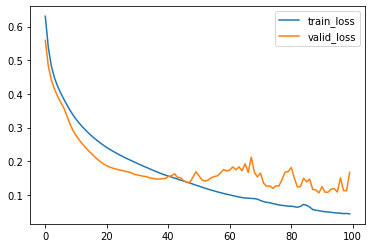

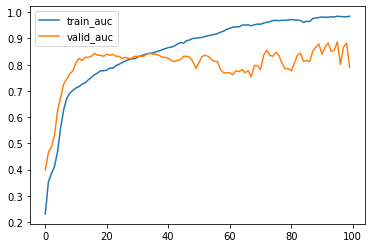

In [40]:
device = 'cuda:0'
model = model.to(device)
model = torch.nn.DataParallel(model, device_ids=[0, 1, 2 ,3])
optimizer = Adam(model.parameters(),lr=1e-4)
loss_fn = nn.BCEWithLogitsLoss()
model = train(model,train_iter,vaild_iter,optimizer,loss_fn,max_epochs=100,log_interval=1,device=device)

In [41]:
torch.save(model.state_dict(),'senet20_wu_add_data_seed126.pt')

In [42]:
model = torch.hub.load(
    'moskomule/senet.pytorch',
    'se_resnet20',
    num_classes=6)
model.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
model.eval()
model = torch.nn.DataParallel(model, device_ids=[0, 1, 2 ,3])

Using cache found in /root/.cache/torch/hub/moskomule_senet.pytorch_master


In [43]:
model.load_state_dict(torch.load('senet20_wu_add_data_seed126.pt'))

<All keys matched successfully>

# model infernce test

In [44]:
from sklearn.metrics import confusion_matrix,accuracy_score
def plot_confusion_matrix(model,data_iter,map_dict=map_dict):
    y_true = np.array([])
    y_pred = np.array([])
    for bx,by in tqdm(data_iter):
        bx = bx.to(device)
        by = by.to(device)
        y_hat = model(bx)
        try:
            if len(y_true) == 0:
                y_true = by.argmax(axis=1).detach().cpu().numpy()
                y_pred = y_hat.argmax(axis=1).detach().cpu().numpy()
            else:
                y_true = np.hstack((y_true,by.argmax(axis=1).detach().cpu().numpy()))
                y_pred = np.hstack((y_pred,y_hat.argmax(axis=1).detach().cpu().numpy()))
        except:
            pass
    cm = pd.DataFrame(confusion_matrix(y_pred,y_true))
    cm.columns = list(map_dict.values())
    acc = accuracy_score(y_pred,y_true)
    return cm,acc

In [45]:
cm,acc = plot_confusion_matrix(model.to(device),train_iter)
print(acc)
cm

100%|██████████| 33/33 [00:02<00:00, 16.17it/s]

0.9050332383665717


Barking  Howling  Crying  COSmoke  GlassBreaking  Vacuum
0      162        4      10        3              9       7
1        2      151      14        0              0       6
2        4       12     140        1              0       3
3        0        0       0      155              0       0
4        0        0       0        0            153       3
5        6        2       9        1              4     192

In [46]:
cm,acc = plot_confusion_matrix(model.to(device),vaild_iter)
print(acc)
cm

100%|██████████| 8/8 [00:01<00:00,  7.08it/s]

0.8916666666666667


Barking  Howling  Crying  COSmoke  GlassBreaking  Vacuum
0       39        2       2        0              0       0
1        1       31       6        0              0       1
2        0        7      31        1              0       1
3        0        0       0       38              0       0
4        0        0       0        0             37       0
5        0        0       1        1              3      38

# submit

In [47]:
print(X_test.shape[0])

10000


In [48]:
sample_submit = pd.read_csv('sample_submission.csv')
model = model.to('cuda:0')
model.eval()
batch = 100
for i in tqdm(range(0,X_test.shape[0]-batch+1,batch)):
    sample_submit.iloc[i:i+batch,1:] = model(X_test[i:i+batch].to(torch.float32).cuda()).detach().cpu().numpy()
sample_submit

100%|██████████| 100/100 [00:04<00:00, 24.27it/s]


Filename   Barking   Howling    Crying   COSmoke  GlassBreaking  \
0       public_00001 -5.422237 -4.243400 -5.353137 -5.653698      -4.442937   
1       public_00002 -4.164351 -5.858186 -4.874871 -4.330256      -4.776301   
2       public_00003 -0.694094 -2.613879 -3.326455 -2.261965      -3.725093   
3       public_00004 -4.912719 -6.803508 -4.265166 -5.847970      -4.756897   
4       public_00005  1.399310 -2.472409 -2.557632 -3.673693      -4.137850   
...              ...       ...       ...       ...       ...            ...   
29995  private_19996  0.166600  0.166600  0.166600  0.166600       0.166600   
29996  private_19997  0.166600  0.166600  0.166600  0.166600       0.166600   
29997  private_19998  0.166600  0.166600  0.166600  0.166600       0.166600   
29998  private_19999  0.166600  0.166600  0.166600  0.166600       0.166600   
29999  private_20000  0.166600  0.166600  0.166600  0.166600       0.166600   

          Other  
0      3.236486  
1      3.398486  
2     -1.488307  
3      3.564304  
4     -2.941719  
...         ...  
29995  0.167000  
29996  0.167000  
29997  0.167000  
29998  0.167000  
29999  0.167000  

[30000 rows x 7 columns]

In [49]:
from scipy.special import softmax
a = softmax(sample_submit.iloc[:,1:].values,axis=1)
a

array([[1.73341679e-04, 5.63463438e-04, 1.85743284e-04, 1.37524777e-04,
        4.61538140e-04, 9.98478389e-01],
       [5.18574598e-04, 9.53208559e-05, 2.54821461e-04, 4.39297973e-04,
        2.81218934e-04, 9.98410766e-01],
       [5.18876711e-01, 7.60872799e-02, 3.73116610e-02, 1.08179892e-01,
        2.50448240e-02, 2.34499633e-01],
       ...,
       [1.66655554e-01, 1.66655554e-01, 1.66655554e-01, 1.66655554e-01,
        1.66655554e-01, 1.66722230e-01],
       [1.66655554e-01, 1.66655554e-01, 1.66655554e-01, 1.66655554e-01,
        1.66655554e-01, 1.66722230e-01],
       [1.66655554e-01, 1.66655554e-01, 1.66655554e-01, 1.66655554e-01,
        1.66655554e-01, 1.66722230e-01]])

In [50]:
sample_submit.iloc[:,1:] = a
sample_submit

Filename   Barking   Howling    Crying   COSmoke  GlassBreaking  \
0       public_00001  0.000173  0.000563  0.000186  0.000138       0.000462   
1       public_00002  0.000519  0.000095  0.000255  0.000439       0.000281   
2       public_00003  0.518877  0.076087  0.037312  0.108180       0.025045   
3       public_00004  0.000208  0.000031  0.000397  0.000082       0.000243   
4       public_00005  0.940585  0.019585  0.017985  0.005891       0.003704   
...              ...       ...       ...       ...       ...            ...   
29995  private_19996  0.166656  0.166656  0.166656  0.166656       0.166656   
29996  private_19997  0.166656  0.166656  0.166656  0.166656       0.166656   
29997  private_19998  0.166656  0.166656  0.166656  0.166656       0.166656   
29998  private_19999  0.166656  0.166656  0.166656  0.166656       0.166656   
29999  private_20000  0.166656  0.166656  0.166656  0.166656       0.166656   

          Other  
0      0.998478  
1      0.998411  
2      0.234500  
3      0.999038  
4      0.012249  
...         ...  
29995  0.166722  
29996  0.166722  
29997  0.166722  
29998  0.166722  
29999  0.166722  

[30000 rows x 7 columns]

In [51]:
sample_submit.sum(axis=1)

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
29995    1.0
29996    1.0
29997    1.0
29998    1.0
29999    1.0
Length: 30000, dtype: float64

In [52]:
# save
sample_submit.to_csv('senet20_wu_add_data_seed126.csv',index=False)
print('done')

done
